<a href="https://colab.research.google.com/github/CanoPablo/Deep_Learning/blob/main/U_Net_satellital.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !unzip "/content/drive/MyDrive/Colegio_Bourbaki/Deep_Learning/Semana_7/Ejercicio3/additional_files_earthcube_emu4zqr.zip" -d "/content/drive/MyDrive/Colegio_Bourbaki/Deep_Learning/Semana_7/Ejercicio3/"

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: /content/drive/MyDrive/Colegio_Bourbaki/Deep_Learning/Semana_7/Ejercicio3/dataset/train/masks/15139.tif  
  inflating: /content/drive/MyDrive/Colegio_Bourbaki/Deep_Learning/Semana_7/Ejercicio3/dataset/train/masks/19699.tif  
  inflating: /content/drive/MyDrive/Colegio_Bourbaki/Deep_Learning/Semana_7/Ejercicio3/dataset/train/masks/8812.tif  
  inflating: /content/drive/MyDrive/Colegio_Bourbaki/Deep_Learning/Semana_7/Ejercicio3/dataset/train/masks/2911.tif  
  inflating: /content/drive/MyDrive/Colegio_Bourbaki/Deep_Learning/Semana_7/Ejercicio3/dataset/train/masks/9831.tif  
  inflating: /content/drive/MyDrive/Colegio_Bourbaki/Deep_Learning/Semana_7/Ejercicio3/dataset/train/masks/216.tif  
  inflating: /content/drive/MyDrive/Colegio_Bourbaki/Deep_Learning/Semana_7/Ejercicio3/dataset/train/masks/8680.tif  
  inflating: /content/drive/MyDrive/Colegio_Bourbaki/Deep_Learning/Semana_7/Ejercicio3/dataset/train/masks

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu May 23 03:16:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   76C    P0              37W /  72W |   8473MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os, os.path
import numpy as np

In [ ]:
# Corroborar el tamaño del dataset

# path joining version for train paths
DIR = '/content/drive/MyDrive/Colegio_Bourbaki/Deep_Learning/Semana_7/Ejercicio3/dataset/train/images'
print(f"Número de Train images: {len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])}")

# path joining version for train paths
DIR = '/content/drive/MyDrive/Colegio_Bourbaki/Deep_Learning/Semana_7/Ejercicio3/dataset/train/masks'
print(f"Número de Train masks: {len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])}")

# path joining version for test paths
DIR = '/content/drive/MyDrive/Colegio_Bourbaki/Deep_Learning/Semana_7/Ejercicio3/dataset/test/images'
print(f"Número de test images: {len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])}")

Número de Train images: 18491
Número de Train masks: 18491
Número de test images: 5043


In [ ]:
import tifffile

def obtener_info_imagen_tiff(ruta_imagen):
    # Abrir la imagen TIFF con tifffile
    imagen = tifffile.imread(ruta_imagen)

    # Obtener el tamaño de la imagen (ancho x alto)
    height, width = imagen.shape[:2]

    # Obtener el número de canales de la imagen
    num_canales = imagen.shape[2] if len(imagen.shape) == 3 else 1

    return width, height, num_canales

In [ ]:
# Especifica la ruta de la imagen TIFF
ruta_imagen_tiff = '/content/drive/MyDrive/Colegio_Bourbaki/Deep_Learning/Semana_7/Ejercicio3/dataset/train/images/1.tif'

# Obtener información de la imagen TIFF
width, height, num_canales = obtener_info_imagen_tiff(ruta_imagen_tiff)

# Imprimir el tamaño y número de canales de la imagen TIFF
print(f'Tamaño de las imágenes: {width} x {height}')
print(f'Número de canales de las imágenes: {num_canales}')

Tamaño de las imágenes: 256 x 256
Número de canales de las imágenes: 4


Efectivamente las impagenes tienen los 4 canales que menciona el reto.

In [ ]:
# Especifica la ruta de la imagen TIFF
ruta_imagen_tiff = '/content/drive/MyDrive/Colegio_Bourbaki/Deep_Learning/Semana_7/Ejercicio3/dataset/train/masks/1.tif'

# Obtener información de la imagen TIFF
width, height, num_canales = obtener_info_imagen_tiff(ruta_imagen_tiff)

# Imprimir el tamaño y número de canales de la imagen TIFF
print(f'Tamaño de las imágenes: {width} x {height}')
print(f'Número de canales de las imágenes: {num_canales}')

Tamaño de las imágenes: 256 x 256
Número de canales de las imágenes: 1


### Utilizando el visualizador del reto.

In [ ]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import random

import numpy as np
from tifffile import TiffFile
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
class LCD():
    """Class to represent the S2GLC Land Cover Dataset for the challenge,
    with useful metadata and statistics.
    """
    # image size of the images and label masks
    IMG_SIZE = 256
    # the images are RGB+NIR (4 channels)
    N_CHANNELS = 4
    # we have 9 classes + a 'no_data' class for pixels with no labels (absent in the dataset)
    N_CLASSES = 10
    CLASSES = [
        'no_data',
        'clouds',
        'artificial',
        'cultivated',
        'broadleaf',
        'coniferous',
        'herbaceous',
        'natural',
        'snow',
        'water'
    ]
    # classes to ignore because they are not relevant. "no_data" refers to pixels without
    # a proper class, but it is absent in the dataset; "clouds" class is not relevant, it
    # is not a proper land cover type and images and masks do not exactly match in time.
    IGNORED_CLASSES_IDX = [0, 1]

    # The training dataset contains 18491 images and masks
    # The test dataset contains 5043 images and masks
    TRAINSET_SIZE = 18491
    TESTSET_SIZE = 5043

    # for visualization of the masks: classes indices and RGB colors
    CLASSES_COLORPALETTE = {
        0: [0,0,0],
        1: [255,25,236],
        2: [215,25,28],
        3: [211,154,92],
        4: [33,115,55],
        5: [21,75,35],
        6: [118,209,93],
        7: [130,130,130],
        8: [255,255,255],
        9: [43,61,255]
        }
    CLASSES_COLORPALETTE = {c: np.asarray(color) for (c, color) in CLASSES_COLORPALETTE.items()}

    # statistics
    # the pixel class counts in the training set
    TRAIN_CLASS_COUNTS = np.array(
        [0, 20643, 60971025, 404760981, 277012377, 96473046, 333407133, 9775295, 1071, 29404605]
    )
    # the minimum and maximum value of image pixels in the training set
    TRAIN_PIXELS_MIN = 1
    TRAIN_PIXELS_MAX = 24356


In [ ]:
DATA_FOLDER_STR = '/content/drive/MyDrive/Colegio_Bourbaki/Deep_Learning/Semana_7/Ejercicio3/dataset'
DATA_FOLDER = Path(DATA_FOLDER_STR).expanduser()
# path to the unzipped dataset: contains directories train/ and test/
DATASET_FOLDER = DATA_FOLDER/'/content/drive/MyDrive/Colegio_Bourbaki/Deep_Learning/Semana_7/Ejercicio3/dataset'

# get all train images and masks
train_images_paths = sorted(list(DATASET_FOLDER.glob('train/images/*.tif')))
train_masks_paths = sorted(list(DATASET_FOLDER.glob('train/masks/*.tif')))
# get all test images
test_images_paths = sorted(list(DATASET_FOLDER.glob('test/images/*.tif')))

### Visualizando imágenes con sus respectivas máscaras.

In [ ]:
def show_image(image, display_min=50, display_max=400, ax=None):
    """Show an image.
    Args:
        image (numpy.array[uint16]): the image. If the image is 16-bit, apply bytescaling to convert to 8-bit
    """
    if image.dtype == np.uint16:
        iscale = display_max - display_min
        scale = 255 / iscale
        byte_im = (image) * scale
        byte_im = (byte_im.clip(0, 255) + 0.5).astype(np.uint8)
        image = byte_im
    # show image
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    ax.axis("off")
    im = ax.imshow(image)
    return im

def show_mask(mask, classes_colorpalette, classes=None, add_legend=True, ax=None):
    """Show a a semantic segmentation mask.
    Args:
       mask (numpy.array[uint8]): the mask in 8-bit
       classes_colorpalette (dict[int, tuple]): dict mapping class index to an RGB color in [0, 1]
       classes (list[str], optional): list of class labels
       add_legend
    """
    show_mask = np.empty((*mask.shape, 3))
    for c, color in classes_colorpalette.items():
        show_mask[mask == c, :] = color
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    ax.axis("off")
    im = ax.imshow(show_mask)
    if add_legend:
        # show legend mapping pixel colors to class names
        import matplotlib.patches as mpatches
        handles = []
        for c, color in classes_colorpalette.items():
            handles.append(mpatches.Patch(color=color, label=classes[c]))
        ax.legend(handles=handles)
    return im

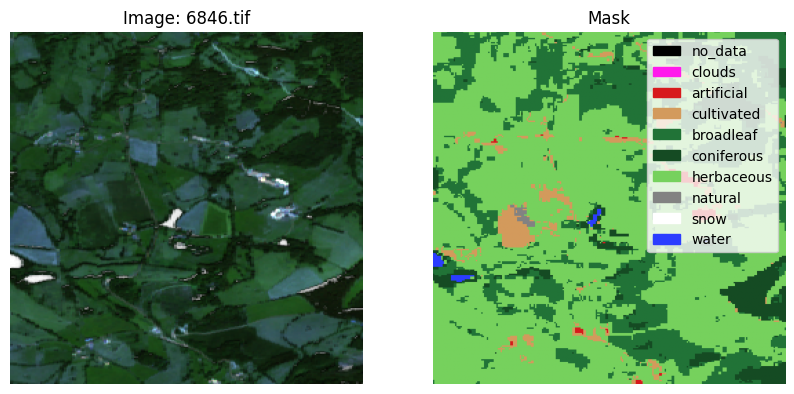

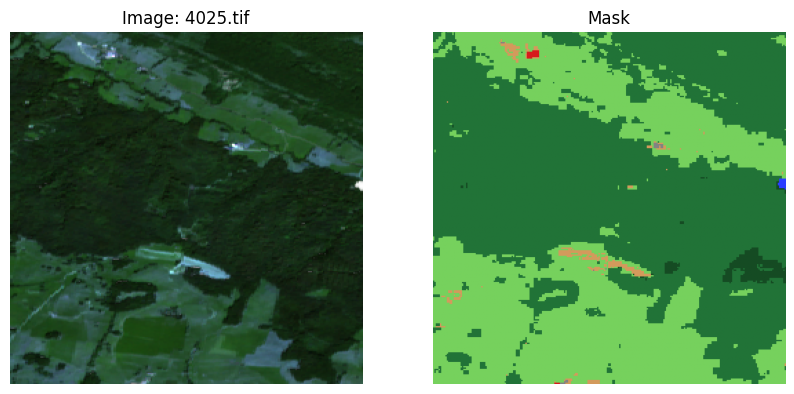

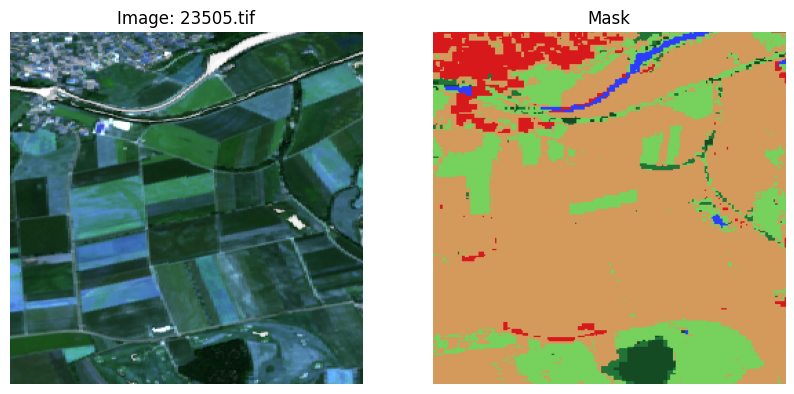

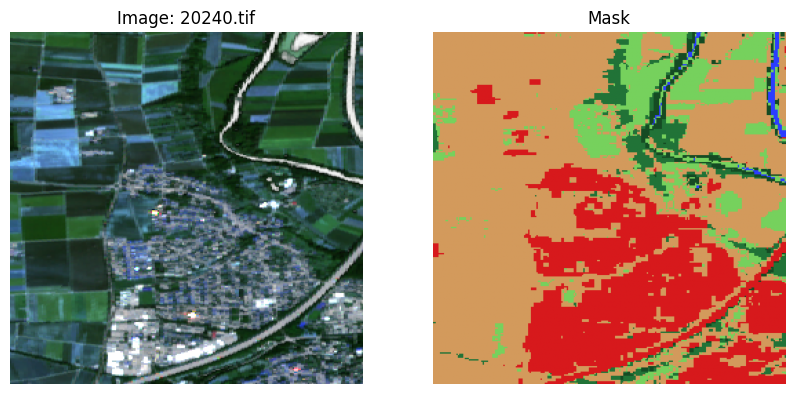

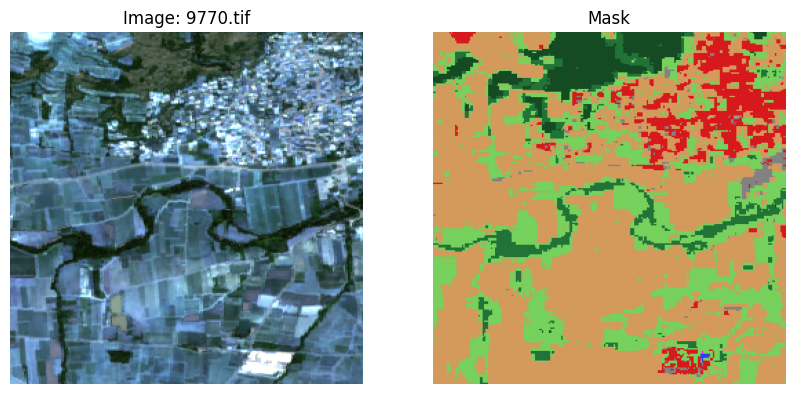

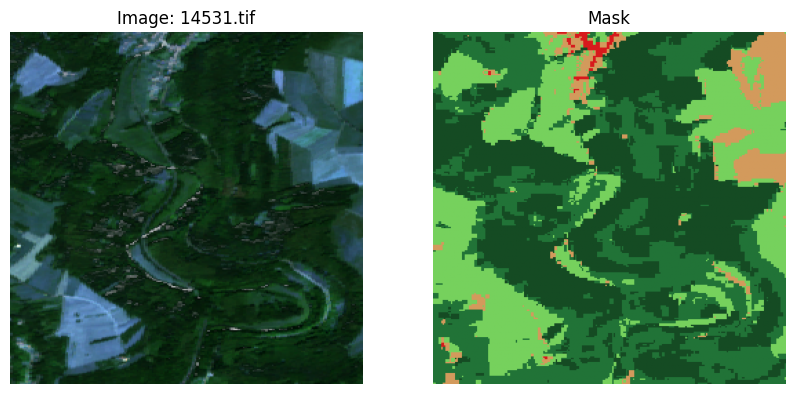

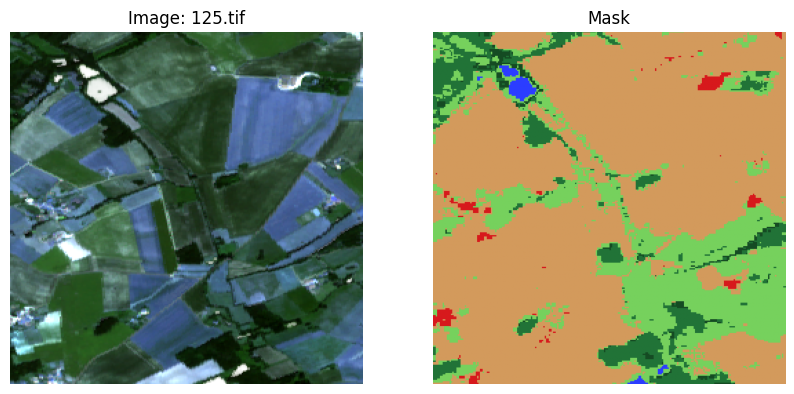

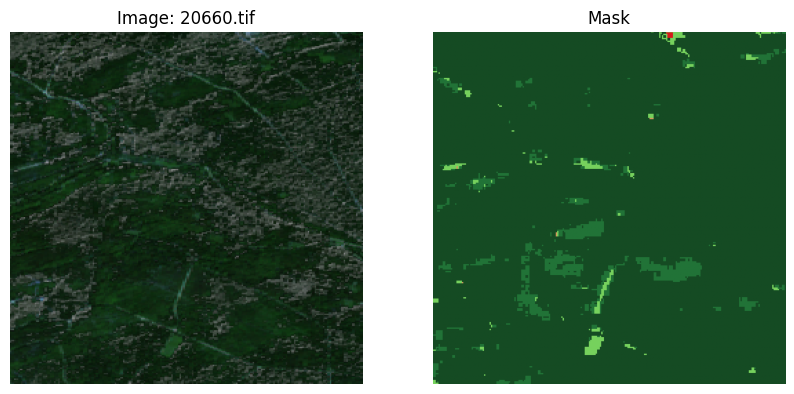

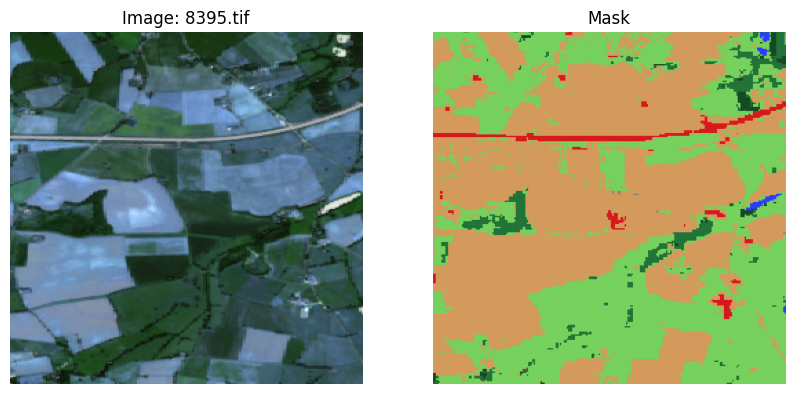

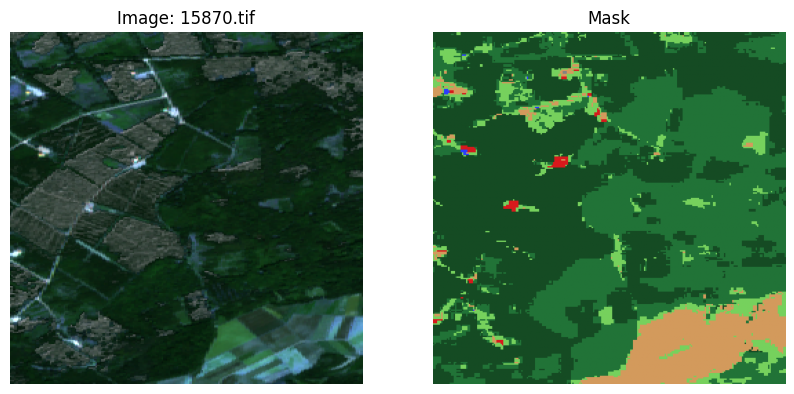

In [ ]:
# Show 10 random (image, mask) pairs from the training set
for k, idx in enumerate(random.sample(range(len(train_images_paths)), 10)):
    image_path = train_images_paths[idx]
    mask_path = train_masks_paths[idx]
    assert image_path.name == mask_path.name

    with TiffFile(image_path) as tif:
        arr = tif.asarray()
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    show_image(arr, display_min=0, display_max=2200, ax=axs[0])

    with TiffFile(mask_path) as tif:
        arr = tif.asarray()
    classes_colorpalette = {c: color/255. for (c, color) in LCD.CLASSES_COLORPALETTE.items()}
    show_mask(arr,
              classes_colorpalette = classes_colorpalette,
              classes=LCD.CLASSES,
              add_legend=(k == 0),
              ax=axs[1]
    )
    axs[0].set_title(f'Image: {image_path.name}')
    axs[1].set_title('Mask')
    #fig.tight_layout()

In [ ]:
# Compute total class distribution in train
def compute_class_counts(masks_paths, n_classes=10):
    """Return the cumulated class counts for all masks in the training set.
    Args:
        masks_paths (list[path-like]): paths to all masks
    """
    cumcount = np.zeros((n_classes,), dtype=np.int64)
    for path in tqdm(train_masks_paths):
        with TiffFile(path) as tif:
            arr = tif.asarray()
            count = np.bincount(arr.ravel(), minlength=10)
            # hist, _ = np.histogram(arr, bins=n_classes, range=(0, 10)) # @todo: use bincount
            cumcount += count
    return cumcount

train_class_counts = compute_class_counts(train_masks_paths, n_classes=LCD.N_CLASSES)
# this should be equal to LandCoverData.TRAIN_CLASS_COUNTS
assert (train_class_counts == LCD.TRAIN_CLASS_COUNTS).all()
# normalize to get a distribution
train_class_dist = train_class_counts / train_class_counts.sum()

 26%|██▌       | 4730/18491 [17:17<50:19,  4.56it/s]


KeyboardInterrupt: 

In [ ]:
def plot_class_distributions(class_counts, classes=None, class_colors=None):
    """Plot the proportion of the number of pixels for every class
    Args:
        class_counts (numpy.array): the raw class counts of shape (N_CLASSES,)
        classes (list[str], optional): list of class labels
        class_colors (numpy.array, optional): array of colors of shape (N_CLASSES, 3) in [0, 1]
    """
    rc_dict = { # font params for display
        'axes.titlesize': 19,
        'axes.labelsize': 16,
        'lines.linewidth': 2,
        'lines.markersize': 8,
        'font.size': 12,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12
    }
    with plt.style.context(['seaborn', rc_dict]):
        class_dist = class_counts / class_counts.sum()
        fig, ax = plt.subplots(figsize=(12, 8))
        rects = ax.bar(range(len(class_dist)), class_dist, color=class_colors)
        ax.set_xticks(range(len(class_dist)))
        if classes is not None:
            ax.set_xticklabels(classes, rotation=90)

        for i, v in enumerate(class_counts):
            ax.text(i, class_dist[i] + 0.005, "{:.2e}".format(v))
        ax.set_xlabel("Classes")
        ax.set_ylabel("Proportion of the number of pixels")
        ax.set_title("Training set")

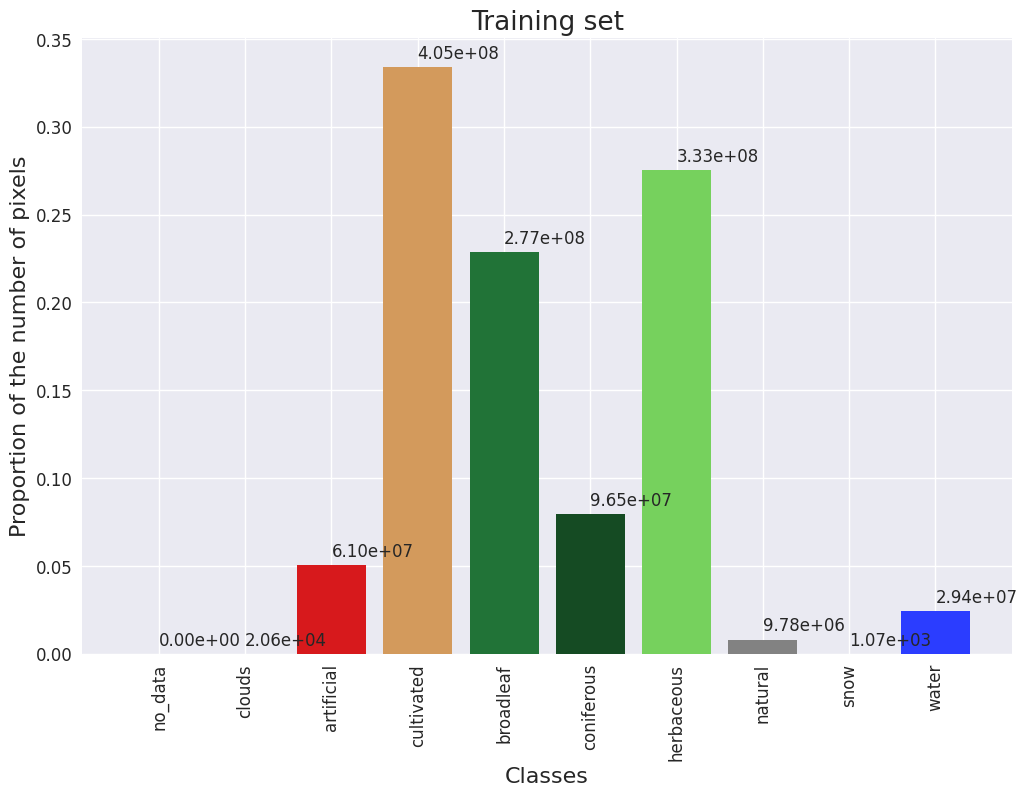

In [ ]:
plot_class_distributions(
    train_class_counts,
    classes=list(LCD.CLASSES),
    class_colors = np.asarray(list(LCD.CLASSES_COLORPALETTE.values()))/255.
)

Como lo indica el reto, la base tiene un fuerte desblance de clases. Veremos si esto impacta en el modelo.

Decidí trabajar con un modelo U-Net por su capacidad para trabajar con segmentación semántica.

# Preparación del dataset

In [ ]:
X_PATH = "/content/drive/MyDrive/Colegio_Bourbaki/Deep_Learning/Semana_7/Ejercicio3/dataset/train/images"
Y_PATH = "/content/drive/MyDrive/Colegio_Bourbaki/Deep_Learning/Semana_7/Ejercicio3/dataset/train/masks"
TEST_PATH = "/content/drive/MyDrive/Colegio_Bourbaki/Deep_Learning/Semana_7/Ejercicio3/dataset/test/images"

In [ ]:
import os
import numpy as np
import random
import cv2
from PIL import Image
from skimage.transform import resize

Era imposible trabajar con todo el dataset en colab y en mi computadora era muy lento. Cargué los archivos a la instancia de Colab.

In [ ]:
# import shutil

In [ ]:
# Directorios locales en Colab
LOCAL_X_PATH = '/content/images'
LOCAL_Y_PATH = '/content/masks'

In [ ]:
# Crear directorios locales
os.makedirs(LOCAL_X_PATH, exist_ok=True)
os.makedirs(LOCAL_Y_PATH, exist_ok=True)

# Copiar archivos a directorios locales
shutil.copytree(X_PATH, LOCAL_X_PATH, dirs_exist_ok=True)
shutil.copytree(Y_PATH, LOCAL_Y_PATH, dirs_exist_ok=True)

'/content/masks'

Decidí tomar una muestra aleatoria de imágenes y máscaras porque Colab no estaba soportando realizar el one hot encoding de las máscaras de entrenamiento para las 10 clases.

In [ ]:
# Listar todos los archivos de imágenes y máscaras
train_image_files = sorted([os.path.join(LOCAL_X_PATH, fname) for fname in os.listdir(LOCAL_X_PATH) if fname.endswith('.tif')])
train_mask_files = sorted([os.path.join(LOCAL_Y_PATH, fname) for fname in os.listdir(LOCAL_Y_PATH) if fname.endswith('.tif')])

# Tomar una muestra aleatoria de archivos
sample_size = 1000  # Puedes ajustar este tamaño según sea necesario
sample_indices = random.sample(range(len(train_image_files)), sample_size)
sample_img_files = [train_image_files[i] for i in sample_indices]
sample_mask_files = [train_mask_files[i] for i in sample_indices]


In [ ]:
# Listar los archivos de imágenes y máscaras
# train_image_files = sorted([f for f in os.listdir(LOCAL_X_PATH) if f.endswith('.tif')])
# train_mask_files = sorted([f for f in os.listdir(LOCAL_Y_PATH) if f.endswith('.tif')])

In [ ]:
# image size of the images and label masks
IMG_SIZE = 256
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 4

# the images are RGB+NIR (4 channels)
N_CHANNELS = 4

N_CLASSES = 10

BATCH_SIZE = 32

In [ ]:
# Inicializar los arrays para almacenar las imágenes y las máscaras
X_train = np.zeros((len(sample_img_files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(sample_mask_files), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)

In [ ]:
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

Genero los tensores para las imágenes y las máscaras.

In [ ]:
print('Resizing training images and masks')
for i, img_file in tqdm(enumerate(sample_img_files), total=len(sample_img_files)):
    # Cargar y redimensionar imágenes
    img_path = os.path.join(LOCAL_X_PATH, img_file)
    img = imread(img_path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[i] = img

    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)

    # Buscar la máscara correspondiente
    mask_file = next((m for m in sample_mask_files if m.startswith(img_file.split('.')[0])), None)
    if mask_file:
        mask_ = imread(os.path.join(LOCAL_Y_PATH, mask_file))
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)

    Y_train[i] = mask

print('Completed resizing training images and masks')

Resizing training images and masks


100%|██████████| 1000/1000 [00:25<00:00, 39.16it/s]

Completed resizing training images and masks


Corroboro las shapes de las imágenes y las máscaras:

In [ ]:
X_train.shape

(1000, 256, 256, 4)

In [ ]:
Y_train.shape

(1000, 256, 256, 1)

In [ ]:
# # Función para procesar cada elemento del dataset
# def preprocess_image_and_mask(image, mask):
#     # Convertir las máscaras a one-hot encoding y eliminar la dimensión extra
#     mask = tf.squeeze(mask, axis=-1)
#     mask = tf.one_hot(mask, depth=10)
#     return image, mask

# # Función para cargar y procesar imágenes
# def load_image(img_path, mask_path):
#     # Leer la imagen
#     img = imread(img_path.numpy().decode('utf-8'))[:,:,:IMG_CHANNELS]
#     img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#     # Leer la máscara
#     mask = imread(mask_path.numpy().decode('utf-8'))
#     mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#     mask = tf.expand_dims(mask, axis=-1)
#     mask = tf.one_hot(tf.cast(mask, tf.int32), N_CLASSES)
#     return img, mask


# # Función de envoltura para tf.data.Dataset
# def load_image_wrapper(img_path, mask_path):
#     img, mask = tf.py_function(func=load_image, inp=[img_path, mask_path], Tout=[tf.float32, tf.float32])
#     img.set_shape((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
#     mask.set_shape((IMG_HEIGHT, IMG_WIDTH, N_CLASSES))
#     return img, mask

# # Listar todos los archivos de imágenes y máscaras
# img_files = sorted([os.path.join(LOCAL_X_PATH, fname) for fname in os.listdir(LOCAL_X_PATH) if fname.endswith('.tif')])
# mask_files = sorted([os.path.join(LOCAL_Y_PATH, fname) for fname in os.listdir(LOCAL_Y_PATH) if fname.endswith('.tif')])

# # Crear el dataset
# dataset = tf.data.Dataset.from_tensor_slices((img_files, mask_files))

# # Aplicar la función de preprocesamiento
# dataset = dataset.map(load_image_wrapper, num_parallel_calls=tf.data.AUTOTUNE)

# # Dividir el dataset en lotes
# dataset = dataset.batch(BATCH_SIZE)

# # Prefetch para mejorar el rendimiento
# dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


## Modelo U-Net

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

Me basé en una U-Net que encontré en línea, el único agregado es el dropout:

https://github.com/bnsreenu/python_for_microscopists/blob/master/076-077-078-Unet_nuclei_tutorial.py

In [ ]:
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=4, BATCH_SIZE = BATCH_SIZE):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    #model.summary()

    return model

In [ ]:
def get_model():
    return multi_unet_model(n_classes=N_CLASSES, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 4)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         592       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

Con mil imágenes Colab aguantó el one hot encoding:

In [ ]:
from tensorflow.keras.utils import to_categorical

# Suponiendo que Y_train tiene valores de clase en el rango [0, 9]
Y_train_one_hot = to_categorical(Y_train, num_classes=10)
print(Y_train_one_hot.shape)  # Debe ser (1000, 256, 256, 10)

(1000, 256, 256, 10)


In [ ]:
#Modelcheckpoint
import tensorflow as tf
checkpointer = tf.keras.callbacks.ModelCheckpoint(r'C:\Users\pablo\Documents\Personal\Colegio_Bourbaki\Deep_Learning\Semana7\Ejercicio3\dataset_pruebas\model.keras',
                                                  verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

In [ ]:
results = model.fit(X_train, Y_train_one_hot, validation_split=0.1, batch_size=BATCH_SIZE, epochs=10)

Epoch 1/10
29/29 [==============================] - 36s 355ms/step - loss: 23.1115 - accuracy: 0.8237 - val_loss: 1.6800e-04 - val_accuracy: 1.0000
Epoch 2/10
29/29 [==============================] - 5s 180ms/step - loss: 0.0228 - accuracy: 0.9989 - val_loss: 5.8854e-06 - val_accuracy: 1.0000
Epoch 3/10
29/29 [==============================] - 5s 179ms/step - loss: 0.0117 - accuracy: 0.9993 - val_loss: 2.9550e-06 - val_accuracy: 1.0000
Epoch 4/10
29/29 [==============================] - 5s 178ms/step - loss: 0.0089 - accuracy: 0.9995 - val_loss: 1.7158e-06 - val_accuracy: 1.0000
Epoch 5/10
29/29 [==============================] - 5s 180ms/step - loss: 0.0069 - accuracy: 0.9996 - val_loss: 1.0391e-06 - val_accuracy: 1.0000
Epoch 6/10
29/29 [==============================] - 5s 181ms/step - loss: 0.0054 - accuracy: 0.9996 - val_loss: 4.3648e-07 - val_accuracy: 1.0000
Epoch 7/10
29/29 [==============================] - 5s 180ms/step - loss: 0.0045 - accuracy: 0.9997 - val_loss: 6.5281e-08

In [ ]:
# Guardar el modelo completo
model.save("/content/drive/MyDrive/Colegio_Bourbaki/Deep_Learning/Semana_7/Ejercicio3/dataset/model.keras")

In [ ]:
from tensorflow.keras.models import load_model
# Cargar el modelo guardado
model = load_model("/content/drive/MyDrive/Colegio_Bourbaki/Deep_Learning/Semana_7/Ejercicio3/dataset/model.keras")

## Test y evaluación

In [ ]:
TEST_PATH = "/content/drive/MyDrive/Colegio_Bourbaki/Deep_Learning/Semana_7/Ejercicio3/dataset/test/images"

In [ ]:
# Directorios locales en Colab
LOCAL_X_test_PATH = '/content/test_images'

In [ ]:
import shutil

# Crear directorios locales
os.makedirs(LOCAL_X_test_PATH, exist_ok=True)

# Copiar archivos a directorios locales
shutil.copytree(TEST_PATH, LOCAL_X_test_PATH, dirs_exist_ok=True)


'/content/test_images'

In [ ]:
# Listar todos los archivos de imágenes y máscaras
test_image_files = sorted([os.path.join(LOCAL_X_test_PATH, fname) for fname in os.listdir(LOCAL_X_test_PATH) if fname.endswith('.tif')])

In [ ]:
len(test_image_files)

5043

De nueva cuenta las 5,043 imágenes estaban rompiendo Colab, tuve que reducirlas a 1000.

In [ ]:
# Limitar el número de archivos a los primeros 1000
test_image_files = test_image_files[:1000]

In [ ]:
# test images
X_test = np.zeros((len(test_image_files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images')
for n, id_ in tqdm(enumerate(test_image_files), total=len(test_image_files)):
    img_path = os.path.join(LOCAL_X_test_PATH, id_)
    img = imread(img_path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

Resizing test images


100%|██████████| 1000/1000 [00:21<00:00, 45.50it/s]


In [ ]:
X_test.shape

(1000, 256, 256, 4)

Evaluando el modelo con el grupo Test

In [ ]:
y_pred = model.predict(X_test, verbose=1)

32/32 [==============================] - 6s 80ms/step


In [ ]:
y_pred[0]

array([[[1.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         1.3509420e-34, 0.0000000e+00, 4.6055761e-37],
        [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 1.9045269e-30],
        [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 8.6084191e-37],
        ...,
        [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 4.0437885e-31]],

       [[1.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.000

## Métrica de evaluación: Kullback-Leibler divergence

In [ ]:
from pathlib import Path
import argparse
import numpy as np
import pandas as pd

In [ ]:
# Cargar el archivo .csv
file_path = "/content/drive/MyDrive/Colegio_Bourbaki/Deep_Learning/Semana_7/Ejercicio3/dataset/test/test_predicted_random_rp2A5Fo.csv"
df = pd.read_csv(file_path)

# Mostrar las primeras filas del archivo para verificar su contenido
print(df.head())

   sample_id  no_data    clouds  artificial  cultivated  broadleaf  \
0      10087      0.0  0.000000    0.049393    0.335312   0.228271   
1      10088      0.0  0.000046    0.050293    0.331955   0.227341   
2      10089      0.0  0.000015    0.050446    0.331375   0.227524   
3      10090      0.0  0.000000    0.048904    0.335876   0.227859   
4      10091      0.0  0.000031    0.051666    0.331314   0.229904   

   coniferous  herbaceous   natural  snow     water  
0    0.078766    0.274628  0.008911   0.0  0.024719  
1    0.079407    0.278122  0.007874   0.0  0.024963  
2    0.083450    0.274460  0.008331   0.0  0.024399  
3    0.079514    0.275848  0.007843   0.0  0.024155  
4    0.078445    0.276199  0.008194   0.0  0.024246  


In [ ]:
df.describe()

sample_id  no_data       clouds   artificial   cultivated  \
count   5043.000000   5043.0  5043.000000  5043.000000  5043.000000   
mean   13728.666667      0.0     0.000017     0.050323     0.334019   
std     2898.353899      0.0     0.000016     0.000848     0.001840   
min    10087.000000      0.0     0.000000     0.046783     0.326248   
25%    11347.500000      0.0     0.000000     0.049744     0.332764   
50%    12608.000000      0.0     0.000015     0.050308     0.334000   
75%    17230.500000      0.0     0.000031     0.050888     0.335266   
max    18491.000000      0.0     0.000107     0.053513     0.340607   

         broadleaf   coniferous   herbaceous      natural          snow  \
count  5043.000000  5043.000000  5043.000000  5043.000000  5.043000e+03   
mean      0.228601     0.079614     0.275089     0.008069  7.927430e-07   
std       0.001619     0.001057     0.001740     0.000347  3.413919e-06   
min       0.223068     0.076431     0.267899     0.006912  0.000000e+00   
25%       0.227478     0.078888     0.273911     0.007843  0.000000e+00   
50%       0.228622     0.079605     0.275085     0.008057  0.000000e+00   
75%       0.229706     0.080307     0.276291     0.008301  0.000000e+00   
max       0.234360     0.083450     0.282074     0.009491  3.051758e-05   

             water  
count  5043.000000  
mean      0.024267  
std       0.000603  
min       0.022018  
25%       0.023865  
50%       0.024261  
75%       0.024673  
max       0.026352

Calcular la divergencia KL para cada par de distribuciones

In [ ]:
import numpy as np
import pandas as pd
from scipy.special import kl_div

# Definición de las clases de pixeles
CLASSES = [
    'no_data', 'clouds', 'artificial', 'cultivated', 'broadleaf',
    'coniferous', 'herbaceous', 'natural', 'snow', 'water'
]


In [ ]:
def calculate_proportions(pred_mask):
    total_pixels = np.prod(pred_mask.shape[:2])
    proportions = np.sum(pred_mask, axis=(0, 1)) / total_pixels
    return proportions

In [ ]:
# Obtener proporciones del CSV (omitimos 'no_data' ya que no está en las predicciones)
csv_proportions = df[CLASSES[1:]].values[:1000]

In [ ]:
csv_proportions

array([[0.00000000e+00, 4.93927002e-02, 3.35311890e-01, ...,
        8.91113281e-03, 0.00000000e+00, 2.47192383e-02],
       [4.57763672e-05, 5.02929688e-02, 3.31954956e-01, ...,
        7.87353516e-03, 0.00000000e+00, 2.49633789e-02],
       [1.52587891e-05, 5.04455566e-02, 3.31375122e-01, ...,
        8.33129883e-03, 0.00000000e+00, 2.43988037e-02],
       ...,
       [0.00000000e+00, 5.02319336e-02, 3.36212158e-01, ...,
        8.20922852e-03, 0.00000000e+00, 2.42156982e-02],
       [0.00000000e+00, 4.86145020e-02, 3.32641602e-01, ...,
        8.37707520e-03, 0.00000000e+00, 2.37731934e-02],
       [0.00000000e+00, 5.07049561e-02, 3.33587646e-01, ...,
        7.96508789e-03, 0.00000000e+00, 2.39715576e-02]])

In [ ]:
y_pred.shape

(1000, 256, 256, 10)

In [ ]:
# Calcular las proporciones predichas
proportions_list = [calculate_proportions(pred_mask) for pred_mask in y_pred]

In [ ]:
# Asegurarte de que las proporciones están normalizadas y listas para la comparación
# En caso de que haya algún problema con la normalización
proportions_list = [prop / np.sum(prop) for prop in proportions_list]
df_proportions = [prop / np.sum(prop) for prop in csv_proportions]

In [ ]:
# Eliminar la clase 'no_data' de las proporciones predichas
proportions_list = [prop[1:] for prop in proportions_list]

In [ ]:
# Calcular divergencia de Kullback-Leibler
def kl_divergence(p, q):
    return np.sum(kl_div(p, q))

kl_divergences = [kl_divergence(pred_proportions, csv_proportions[i])
                  for i, pred_proportions in enumerate(proportions_list)]

# Convertir a DataFrame para análisis adicional
kl_div_df = pd.DataFrame({'sample_id': df_first_1000['sample_id'], 'kl_divergence': kl_divergences})

print(kl_div_df)


     sample_id  kl_divergence
0        10087      -0.000009
1        10088      -0.000010
2        10089      -0.000010
3        10090      -0.000009
4        10091      -0.000010
..         ...            ...
995      11082      -0.000009
996      11083      -0.000011
997      11084      -0.000009
998      11085      -0.000009
999      11086      -0.000009

[1000 rows x 2 columns]


La desviación entre distribuciones es muy baja pero necesito revisar los valores de las máscaras obtenidas por el modelo.

### Validaciones

In [ ]:
# Verificar algunas proporciones predichas y del CSV
print("Predicted proportions sample:")
print(proportions_list[:5])

print("CSV proportions sample:")
print(csv_proportions[:5])

Predicted proportions sample:
[array([4.78278367e-36, 6.35372490e-16, 2.22811299e-33, 9.69879283e-41,
       3.74951944e-27, 1.16596470e-34, 9.41875889e-22, 0.00000000e+00,
       5.17550242e-18]), array([1.16286525e-39, 2.05163067e-10, 3.21100476e-19, 4.42441350e-32,
       2.67922253e-29, 2.29685846e-23, 1.17821036e-13, 0.00000000e+00,
       3.66633024e-21]), array([5.93001388e-43, 9.84114998e-14, 5.16115029e-41, 1.44049231e-36,
       1.53206337e-32, 2.87796164e-32, 5.83807421e-26, 1.49769712e-34,
       1.00219741e-20]), array([5.76752062e-39, 4.89003611e-21, 6.27044949e-26, 9.40697152e-38,
       6.00866633e-31, 8.83109785e-31, 9.50467127e-19, 7.55852544e-38,
       4.05243657e-17]), array([4.16583213e-34, 6.07844781e-18, 9.60584173e-31, 0.00000000e+00,
       2.96589678e-33, 1.15698672e-36, 3.72433981e-23, 1.99807823e-35,
       2.03400675e-19])]
CSV proportions sample:
[[0.00000000e+00 4.93927002e-02 3.35311890e-01 2.28271484e-01
  7.87658691e-02 2.74627686e-01 8.91113281e-03 0

Los valores del modelo son demasiado pequeños, lo que sugiere un sobreajuste (aunque el performance en el grupo de validación es excelente también). Probablemente obtengo un buen Kullback-Leibler divergence porque las distribuciones son muy parecidas pero debería realizar una revisión del entrenamiento y acompañar con otra métrica para evaluar el performance, como IoU (Intersection over Union), F1 score, o la precisión y el recall por clase.

El problema es que la carga de las imágenes y las máscaras en Colab tomó 10 horas, entonces por ahora no me da tiempo de volver a hacer la carga, me queda como pendiente para los próximos días 🤙

# FIN